# 1. Introduction

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>1.1 Context</b></p>
</div>

Denoising autoencoder implemenation for the Porto Seguro's Safe Driver Prediction competition.

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>1.2 Used code</b></p>
</div>

The code used is adapted from the chapter Setting up a denoising autoencoder and a DNN in [The Kaggle Workbook](https://www.amazon.com/Kaggle-Workbook-Self-learning-exercises-competitions/dp/1804611212) by [(Banachewicz & Massaron)](#5.-References) and directly from the workbook [workbook_dae](https://www.kaggle.com/code/lucamassaron/workbook-dae) by [Luca Massaron](https://www.kaggle.com/lucamassaron).

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>1.3 Libraries</b></p>
</div>

In [1]:
import gc
import optuna
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from path import Path
from numba import jit

from sklearn.model_selection import StratifiedKFold

from scipy.special import erfinv

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation, LeakyReLU
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

In [2]:
def gpu_cleanup(objects):
    if objects:
        del(objects)
    K.clear_session()
    gc.collect()

# 2. Data Processing

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2.1 Configuration Class</b></p>
</div>

For ease of use and modifiability we are using a config class. This allows us to have all parameters in one place and easily change them without having to go through the code having to look for changes we missed. 

In [3]:
class Config:
    input_directory = Path('../input/porto-seguro-safe-driver-prediction')
    dae_batch_size = 128
    dae_num_epoch = 50
    dae_architecture = [1500, 1500, 1500]
    reuse_autoencoder = False

    batch_size = 128
    num_epoch = 150
    units = [64, 32]
    input_dropout=0.06
    dropout=0.08
    regL2=0.09
    activation='selu'
    
    cv_folds = 5
    nas = False
    random_state = 0
    
config = Config()

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2.2 Loading the data</b></p>
</div>

In [4]:
train = pd.read_csv(config.input_directory / 'train.csv', index_col='id')
test = pd.read_csv(config.input_directory / 'test.csv', index_col='id')
submission = pd.read_csv(config.input_directory / 'sample_submission.csv', index_col='id')

In [5]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [6]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [7]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [8]:
calc_features = [feat for feat in train.columns if "_calc" in feat]
cat_features = [feat for feat in train.columns if "_cat" in feat]

In [9]:
# Extracting target
target = train["target"].values
train = train.drop("target", axis="columns")

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2.3 Dropping the calc features</b></p>
</div>

We are dropping the calc features as discussed here: [Why removing ps_calc features improve the results?](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/discussion/41970)

In [10]:
train = train.drop(calc_features, axis="columns")
test = test.drop(calc_features, axis="columns")

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2.4 One-hot Encoding of cat features</b></p>
</div>

In [11]:
train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

In [12]:
assert((train.columns==test.columns).all())

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>2.5 Normalization</b></p>
</div>

All features that are not binary or one-hot-encoded categorical need to be normalized. 

"Instead of using statistical normalization (bringing your distribution of values to have zero mean and unit standard deviation), GaussRank is a procedure that also allows the modification of the distribution of the variables into a transformed Gaussian one."[(The Kaggle Workbook)](https://www.amazon.com/Kaggle-Workbook-Self-learning-exercises-competitions/dp/1804611212)


In [13]:
print("Applying GaussRank to columns: ", end='')
to_normalize = list()
for k, col in enumerate(train.columns):
    if '_bin' not in col and '_cat' not in col and '_missing' not in col:
        to_normalize.append(col)
print(to_normalize)

def to_gauss(x): return np.sqrt(2) * erfinv(x) 

def normalize(data, norm_cols):
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)
        normal = to_gauss(uniform)
        normalized_col = pd.Series(index=sorted_idx, data=normal)
        data[col] = normalized_col
    return data

train = normalize(train, to_normalize)
test = normalize(test, to_normalize)

Applying GaussRank to columns: ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


In [14]:
features = train.columns
train_index = train.index
test_index = test.index

train = train.values.astype(np.float32)
test = test.values.astype(np.float32)

# 3. Helper Functions

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.1 Plot function</b></p>
</div>

In [15]:
def plot_keras_history(history, measures):
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        try:
            panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        except:
            pass
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.2 Evaluation Function</b></p>
</div>

Normalized Gini coefficient.

In [16]:
@jit
def eval_gini(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_pred)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

# 3. Core Functions

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.1 Mixup Generator</b></p>
</div>

The batch generator is part of the mixup generator as it provides shuffled chunks of data based on batch size.

In [17]:
def batch_generator(x, batch_size, shuffle=True, random_state=None):
    batch_index = 0
    n = x.shape[0]
    while True:
        if batch_index == 0:
            index_array = np.arange(n)
            if shuffle:
                np.random.seed(seed=random_state)
                index_array = np.random.permutation(n)

        current_index = (batch_index * batch_size) % n
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1
        else:
            current_batch_size = n - current_index
            batch_index = 0

        batch = x[index_array[current_index: current_index + current_batch_size]]

        yield batch


"The mixup_generator is a generator that returns batches of data whose values have been partially swapped to create some noise and augment the data to avoid the DAE overfitting to the training dataset."[(The Kaggle Workbook)](https://www.amazon.com/Kaggle-Workbook-Self-learning-exercises-competitions/dp/1804611212)


In [18]:
def mixup_generator(X, batch_size, swaprate=0.15, shuffle=True, random_state=None):
    if random_state is None:
        random_state = np.randint(0, 999)

    num_features = X.shape[1]
    num_swaps = int(num_features * swaprate)    
    generator_a = batch_generator(X, batch_size, shuffle, random_state)
    generator_b = batch_generator(X, batch_size, shuffle, random_state + 1)

    while True:
        batch = next(generator_a)
        mixed_batch = batch.copy()
        effective_batch_size = batch.shape[0]
        alternative_batch = next(generator_b)
        assert((batch != alternative_batch).any())
        for i in range(effective_batch_size):
            swap_idx = np.random.choice(num_features, num_swaps, replace=False)
            mixed_batch[i, swap_idx] = alternative_batch[i, swap_idx]
        yield (mixed_batch, batch)

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.2 Denoising Autoencoder</b></p>
</div>

In [19]:
def extract_dae_features(autoencoder, X, layers=[3]):
    data = []
    for layer in layers:
        if layer==0:
            data.append(X)
        else:
            get_layer_output = Model([autoencoder.layers[0].input], [autoencoder.layers[layer].output])
            layer_output = get_layer_output.predict(X, batch_size=128)
            data.append(layer_output)
    data = np.hstack(data)
    return data

In [20]:
def get_DAE(X, architecture=[1500, 1500, 1500]):
    features = X.shape[1]
    inputs = Input((features,))
    for i, nodes in enumerate(architecture):
        layer = Dense(nodes, activation='relu', use_bias=False, name=f"code_{i+1}")
        if i==0:
            x = layer(inputs)
        else:
            x = layer(x)
        x = BatchNormalization()(x)
    outputs = Dense(features, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model

In [21]:
def autoencoder_fitting(X_train, X_valid, filename='dae', random_state=None, suppress_output=False):
    if suppress_output:
        verbose = 0
    else:
        verbose = 2
        print("Fitting a denoising autoencoder")

    tf.random.set_seed(seed=random_state)
    generator = mixup_generator(X_train, 
                                batch_size=config.dae_batch_size, 
                                swaprate=0.15, 
                                random_state=config.random_state)
                                
    dae = get_DAE(X_train, architecture=config.dae_architecture)
    steps_per_epoch = np.ceil(X_train.shape[0] / config.dae_batch_size)

    early_stopping = EarlyStopping(monitor='val_mse', 
                                mode='min', 
                                patience=5, 
                                restore_best_weights=True,
                                verbose=0)

    history = dae.fit(generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=config.dae_num_epoch,
                    validation_data=(X_valid, X_valid),
                    callbacks=[early_stopping],
                    verbose=verbose)

    if not suppress_output: plot_keras_history(history, measures=['mse', 'mae'])

    dae.save(filename)

    return dae

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.3 Supervised Neural Network Model</b></p>
</div>

In [22]:
def dense_blocks(x, units, activation, regL2, dropout):
    kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=config.random_state)
    for k, layer_units in enumerate(units):
        if regL2 > 0:
            x = Dense(layer_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=l2(regL2))(x)
        else:
            x = Dense(layer_units, kernel_initializer=kernel_initializer, activation=activation)(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
    return x

In [23]:
def dnn_model(dae, units=[4500, 1000, 1000], 
            input_dropout=0.1, dropout=0.5,
            regL2=0.05,
            activation='relu'):
    
    inputs = dae.get_layer("code_2").output
    if input_dropout > 0:
        x = Dropout(input_dropout)(inputs)
    else:
        x = tf.keras.layers.Layer()(inputs)
    x = dense_blocks(x, units, activation, regL2, dropout)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=dae.input, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.binary_crossentropy,
                metrics=[AUC(name='auc')])
    return model


In [24]:
def model_fitting(X_train, y_train, X_valid, y_valid, autoencoder, filename, random_state=None, suppress_output=False):
        if suppress_output:
            verbose = 0
        else:
            verbose = 2
            print("Fitting model")

        early_stopping = EarlyStopping(monitor='val_auc', 
                                    mode='max', 
                                    patience=10, 
                                    restore_best_weights=True,
                                    verbose=0)

        rlrop = ReduceLROnPlateau(monitor='val_auc', 
                                mode='max',
                                patience=2,
                                factor=0.75,
                                verbose=0)
        
        tf.random.set_seed(seed=random_state)

        model = dnn_model(autoencoder,
                    units=config.units,
                    input_dropout=config.input_dropout,
                    dropout=config.dropout,
                    regL2=config.regL2,
                    activation=config.activation)
        
        history = model.fit(X_train, y_train, 
                            epochs=config.num_epoch, 
                            batch_size=config.batch_size, 
                            validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping, rlrop],
                            shuffle=True,
                            verbose=verbose)

        model.save(filename)
        
        if not suppress_output:  plot_keras_history(history, measures=['loss', 'auc'])

        return model, history

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>3.4 Optimization</b></p>
</div>

In [25]:
if config.nas is True:
    def evaluate():
        metric_evaluations = list()

        skf = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)

        for k, (train_idx, valid_idx) in enumerate(skf.split(train, target)):
            
            X_train, y_train = train[train_idx, :], target[train_idx]
            X_valid, y_valid = train[valid_idx, :], target[valid_idx]

            if config.reuse_autoencoder:
                autoencoder = load_model(f"./dae_fold_{k}")
            else:
                autoencoder = autoencoder_fitting(X_train, X_valid,
                                                filename=f'./dae_fold_{k}', 
                                                random_state=config.random_state,
                                                suppress_output=True)
            
            model, _ = model_fitting(X_train, y_train, X_valid, y_valid,
                                        autoencoder=autoencoder,
                                        filename=f"dnn_model_fold_{k}", 
                                        random_state=config.random_state,
                                        suppress_output=True)
            
            val_preds = model.predict(X_valid, batch_size=128, verbose=0)
            best_score = eval_gini(y_true=y_valid, y_pred=np.ravel(val_preds))
            metric_evaluations.append(best_score)
            
            gpu_cleanup([autoencoder, model])
        
        return np.mean(metric_evaluations)

    def objective(trial):
        params = {
                'first_layer': trial.suggest_categorical("first_layer", [8, 16, 32, 64, 128, 256, 512]),
                'second_layer': trial.suggest_categorical("second_layer", [0, 8, 16, 32, 64, 128, 256]),
                'third_layer': trial.suggest_categorical("third_layer", [0, 8, 16, 32, 64, 128, 256]),
                'input_dropout': trial.suggest_float("input_dropout", 0.0, 0.5),
                'dropout': trial.suggest_float("dropout", 0.0, 0.5),
                'regL2': trial.suggest_uniform("regL2", 0.0, 0.1),
                'activation': trial.suggest_categorical("activation", ['relu', 'leaky-relu', 'selu'])
        }

        config.units = [nodes for nodes in [params['first_layer'], params['second_layer'], params['third_layer']] if nodes > 0]
        config.input_dropout = params['input_dropout']
        config.dropout = params['dropout']
        config.regL2 = params['regL2']
        config.activation = params['activation']
        
        return evaluate()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=60)

    print("Best Gini Normalized Score", study.best_value)
    print("Best parameters", study.best_params)

    config.units = [nodes for nodes in [study.best_params['first_layer'], study.best_params['second_layer'], study.best_params['third_layer']] if nodes > 0]
    config.input_dropout = study.best_params['input_dropout']
    config.dropout = study.best_params['dropout']
    config.regL2 = study.best_params['regL2']
    config.activation = study.best_params['activation']

# 4. Training and Submission

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>4.1 Training</b></p>
</div>

CV fold 0
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 37s - loss: 0.0327 - mse: 0.0327 - mae: 0.0935 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1093 - 37s/epoch - 10ms/step
Epoch 2/50
3721/3721 - 35s - loss: 0.0222 - mse: 0.0222 - mae: 0.0705 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.0785 - 35s/epoch - 9ms/step
Epoch 3/50
3721/3721 - 32s - loss: 0.0196 - mse: 0.0196 - mae: 0.0610 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0677 - 32s/epoch - 9ms/step
Epoch 4/50
3721/3721 - 35s - loss: 0.0177 - mse: 0.0177 - mae: 0.0534 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0482 - 35s/epoch - 9ms/step
Epoch 5/50
3721/3721 - 32s - loss: 0.0163 - mse: 0.0163 - mae: 0.0472 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0354 - 32s/epoch - 9ms/step
Epoch 6/50
3721/3721 - 32s - loss: 0.0154 - mse: 0.0154 - mae: 0.0429 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0274 - 32s/epoch - 9ms/step
Epoch 7/50
3721/3721 - 35s - loss: 0.0149 - mse: 0.0149 - mae: 0.0407

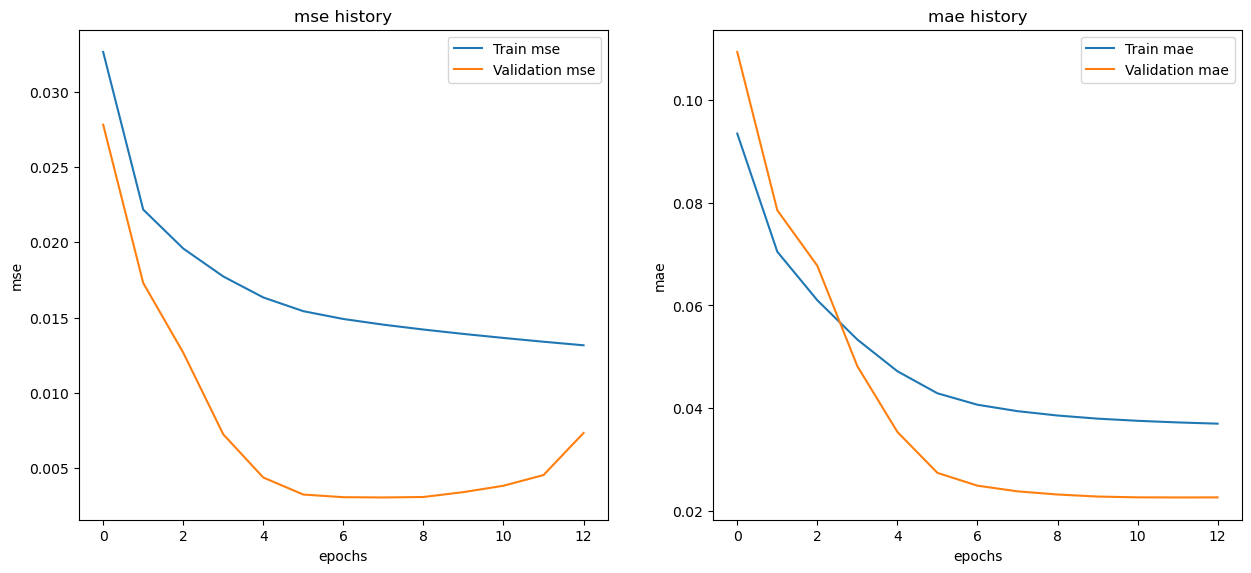

Fitting model
Epoch 1/150
3721/3721 - 20s - loss: 1.7815 - auc: 0.5674 - val_loss: 0.1620 - val_auc: 0.6272 - lr: 0.0010 - 20s/epoch - 5ms/step
Epoch 2/150
3721/3721 - 18s - loss: 0.1599 - auc: 0.6036 - val_loss: 0.1610 - val_auc: 0.6331 - lr: 0.0010 - 18s/epoch - 5ms/step
Epoch 3/150
3721/3721 - 18s - loss: 0.1574 - auc: 0.6184 - val_loss: 0.1550 - val_auc: 0.6383 - lr: 0.0010 - 18s/epoch - 5ms/step
Epoch 4/150
3721/3721 - 18s - loss: 0.1560 - auc: 0.6292 - val_loss: 0.1575 - val_auc: 0.6397 - lr: 0.0010 - 18s/epoch - 5ms/step
Epoch 5/150
3721/3721 - 18s - loss: 0.1546 - auc: 0.6500 - val_loss: 0.1584 - val_auc: 0.6281 - lr: 0.0010 - 18s/epoch - 5ms/step
Epoch 6/150
3721/3721 - 18s - loss: 0.1534 - auc: 0.6650 - val_loss: 0.1569 - val_auc: 0.6280 - lr: 0.0010 - 18s/epoch - 5ms/step
Epoch 7/150
3721/3721 - 18s - loss: 0.1504 - auc: 0.6949 - val_loss: 0.1604 - val_auc: 0.6080 - lr: 7.5000e-04 - 18s/epoch - 5ms/step
Epoch 8/150
3721/3721 - 17s - loss: 0.1479 - auc: 0.7186 - val_loss: 0.1

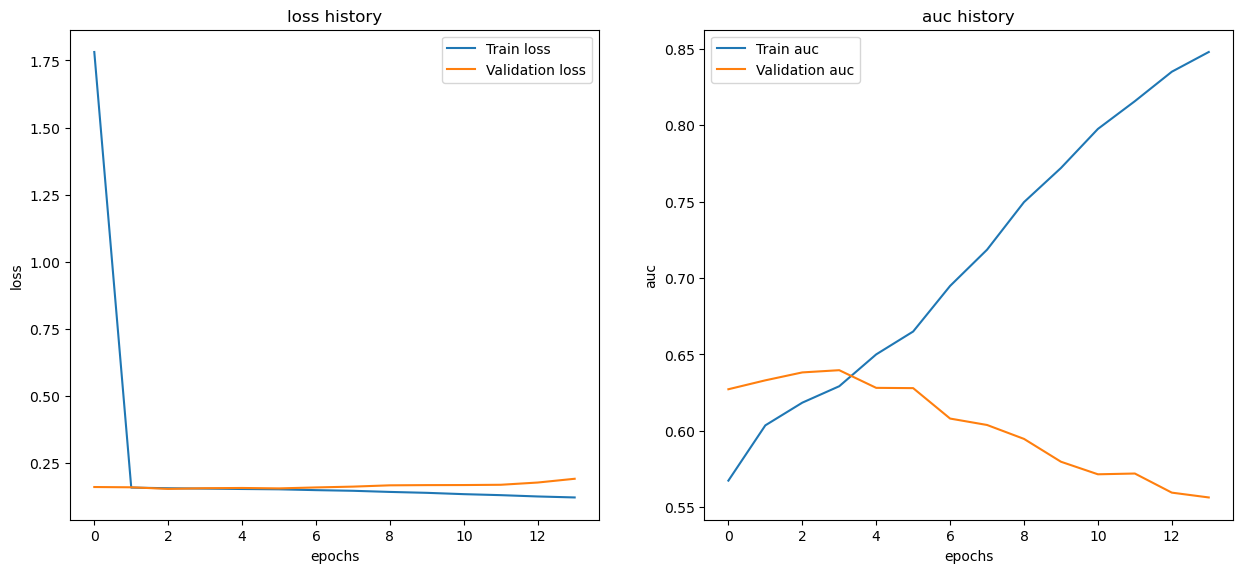

931/931 [==============================] - 2s 2ms/step
[best epoch is 4]	validation_0-gini_dnn: 0.28180

931/931 [==============================] - 2s 2ms/step
CV fold 1
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 35s - loss: 0.0328 - mse: 0.0328 - mae: 0.0916 - val_loss: 0.0224 - val_mse: 0.0224 - val_mae: 0.0873 - 35s/epoch - 9ms/step
Epoch 2/50
3721/3721 - 32s - loss: 0.0222 - mse: 0.0222 - mae: 0.0663 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.0707 - 32s/epoch - 9ms/step
Epoch 3/50
3721/3721 - 35s - loss: 0.0195 - mse: 0.0195 - mae: 0.0569 - val_loss: 0.0130 - val_mse: 0.0130 - val_mae: 0.0572 - 35s/epoch - 10ms/step
Epoch 4/50
3721/3721 - 35s - loss: 0.0178 - mse: 0.0178 - mae: 0.0511 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0472 - 35s/epoch - 9ms/step
Epoch 5/50
3721/3721 - 33s - loss: 0.0166 - mse: 0.0166 - mae: 0.0470 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0362 - 33s/epoch - 9ms/step
Epoch 6/50
3721/3721 - 32s - loss: 0.0157 - mse: 0.0157 -

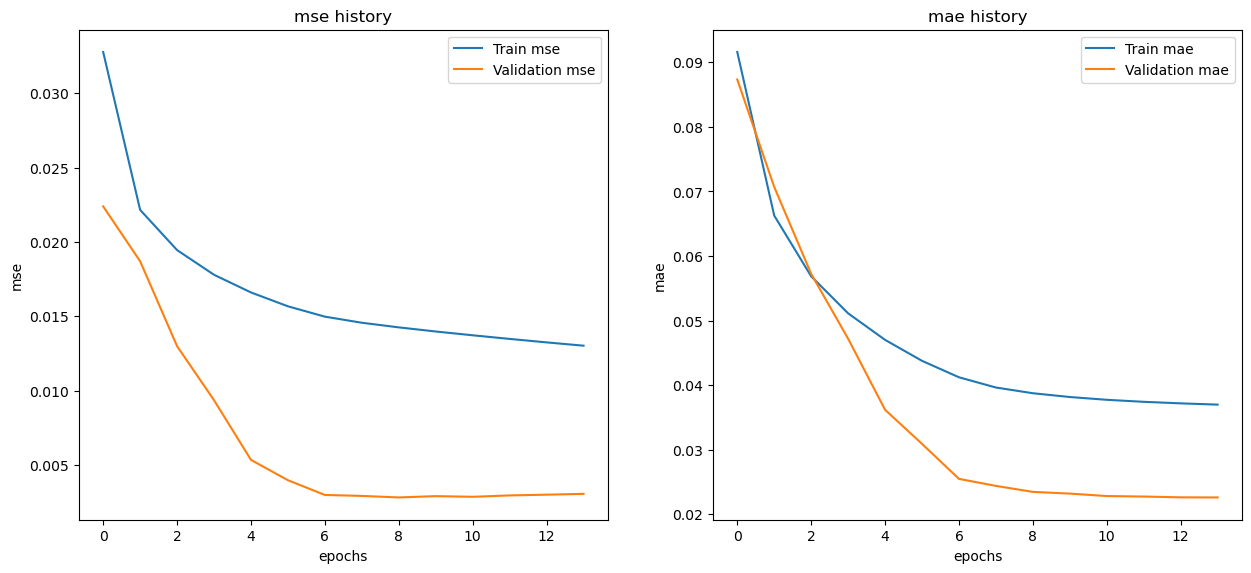

Fitting model
Epoch 1/150
3721/3721 - 19s - loss: 2.1517 - auc: 0.5666 - val_loss: 0.1607 - val_auc: 0.6141 - lr: 0.0010 - 19s/epoch - 5ms/step
Epoch 2/150
3721/3721 - 16s - loss: 0.1606 - auc: 0.6012 - val_loss: 0.1589 - val_auc: 0.6095 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 3/150
3721/3721 - 17s - loss: 0.1574 - auc: 0.6238 - val_loss: 0.1555 - val_auc: 0.6255 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 4/150
3721/3721 - 16s - loss: 0.1560 - auc: 0.6349 - val_loss: 0.1639 - val_auc: 0.6183 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 5/150
3721/3721 - 17s - loss: 0.1547 - auc: 0.6504 - val_loss: 0.1556 - val_auc: 0.6184 - lr: 0.0010 - 17s/epoch - 5ms/step
Epoch 6/150
3721/3721 - 17s - loss: 0.1522 - auc: 0.6763 - val_loss: 0.1562 - val_auc: 0.6091 - lr: 7.5000e-04 - 17s/epoch - 4ms/step
Epoch 7/150
3721/3721 - 17s - loss: 0.1502 - auc: 0.6996 - val_loss: 0.1578 - val_auc: 0.6096 - lr: 7.5000e-04 - 17s/epoch - 5ms/step
Epoch 8/150
3721/3721 - 17s - loss: 0.1468 - auc: 0.7283 - val_loss:

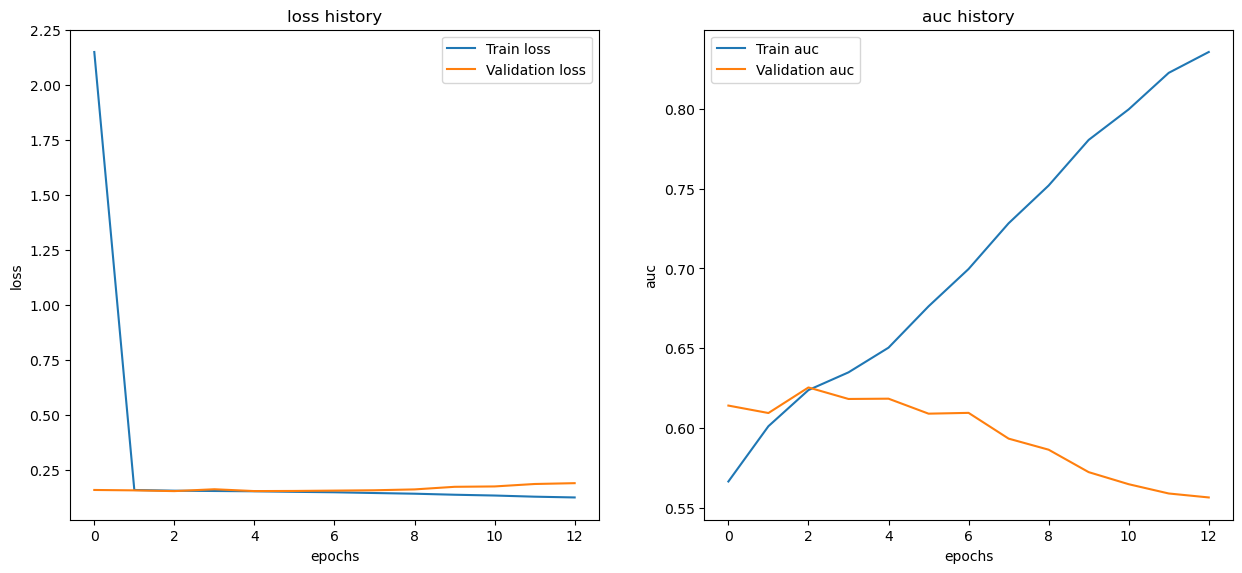

931/931 [==============================] - 2s 2ms/step
[best epoch is 3]	validation_0-gini_dnn: 0.25641

931/931 [==============================] - 2s 2ms/step
CV fold 2
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 35s - loss: 0.0324 - mse: 0.0324 - mae: 0.0912 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0812 - 35s/epoch - 10ms/step
Epoch 2/50
3721/3721 - 35s - loss: 0.0221 - mse: 0.0221 - mae: 0.0660 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0702 - 35s/epoch - 9ms/step
Epoch 3/50
3721/3721 - 32s - loss: 0.0195 - mse: 0.0195 - mae: 0.0566 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0621 - 32s/epoch - 9ms/step
Epoch 4/50
3721/3721 - 35s - loss: 0.0179 - mse: 0.0179 - mae: 0.0509 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0480 - 35s/epoch - 9ms/step
Epoch 5/50
3721/3721 - 32s - loss: 0.0167 - mse: 0.0167 - mae: 0.0468 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0391 - 32s/epoch - 9ms/step
Epoch 6/50
3721/3721 - 35s - loss: 0.0158 - mse: 0.0158 -

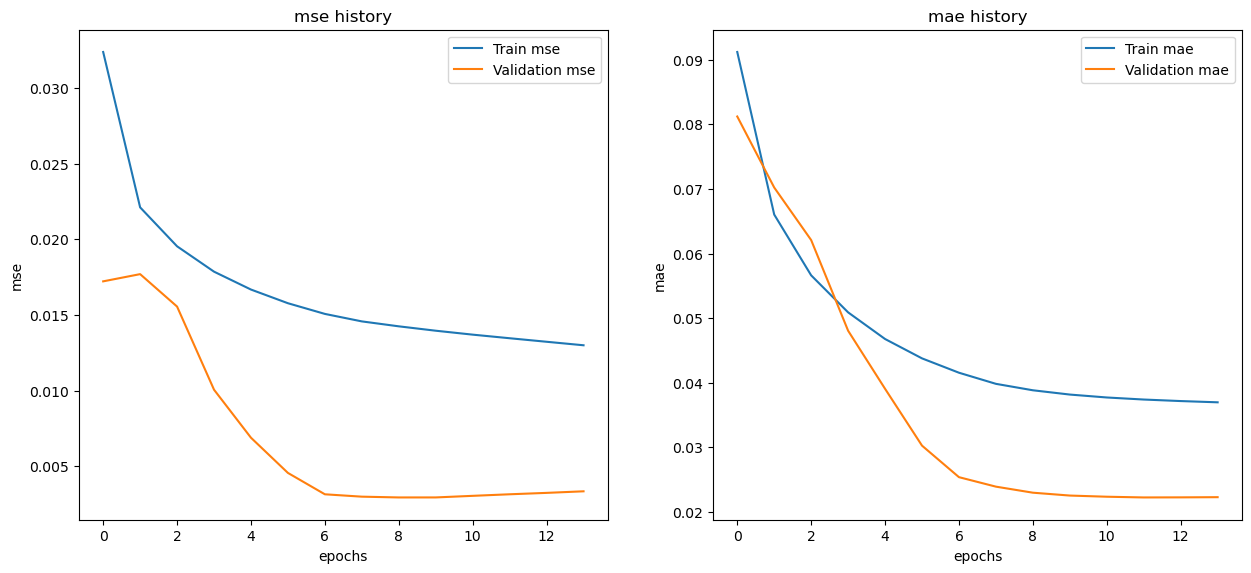

Fitting model
Epoch 1/150
3721/3721 - 19s - loss: 1.9009 - auc: 0.5720 - val_loss: 0.1579 - val_auc: 0.6218 - lr: 0.0010 - 19s/epoch - 5ms/step
Epoch 2/150
3721/3721 - 17s - loss: 0.1597 - auc: 0.6094 - val_loss: 0.1564 - val_auc: 0.6235 - lr: 0.0010 - 17s/epoch - 5ms/step
Epoch 3/150
3721/3721 - 16s - loss: 0.1576 - auc: 0.6194 - val_loss: 0.1583 - val_auc: 0.6317 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 4/150
3721/3721 - 17s - loss: 0.1563 - auc: 0.6332 - val_loss: 0.1553 - val_auc: 0.6313 - lr: 0.0010 - 17s/epoch - 5ms/step
Epoch 5/150
3721/3721 - 17s - loss: 0.1549 - auc: 0.6493 - val_loss: 0.1546 - val_auc: 0.6296 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 6/150
3721/3721 - 17s - loss: 0.1522 - auc: 0.6754 - val_loss: 0.1629 - val_auc: 0.6224 - lr: 7.5000e-04 - 17s/epoch - 4ms/step
Epoch 7/150
3721/3721 - 17s - loss: 0.1502 - auc: 0.6988 - val_loss: 0.1611 - val_auc: 0.6077 - lr: 7.5000e-04 - 17s/epoch - 4ms/step
Epoch 8/150
3721/3721 - 17s - loss: 0.1468 - auc: 0.7290 - val_loss:

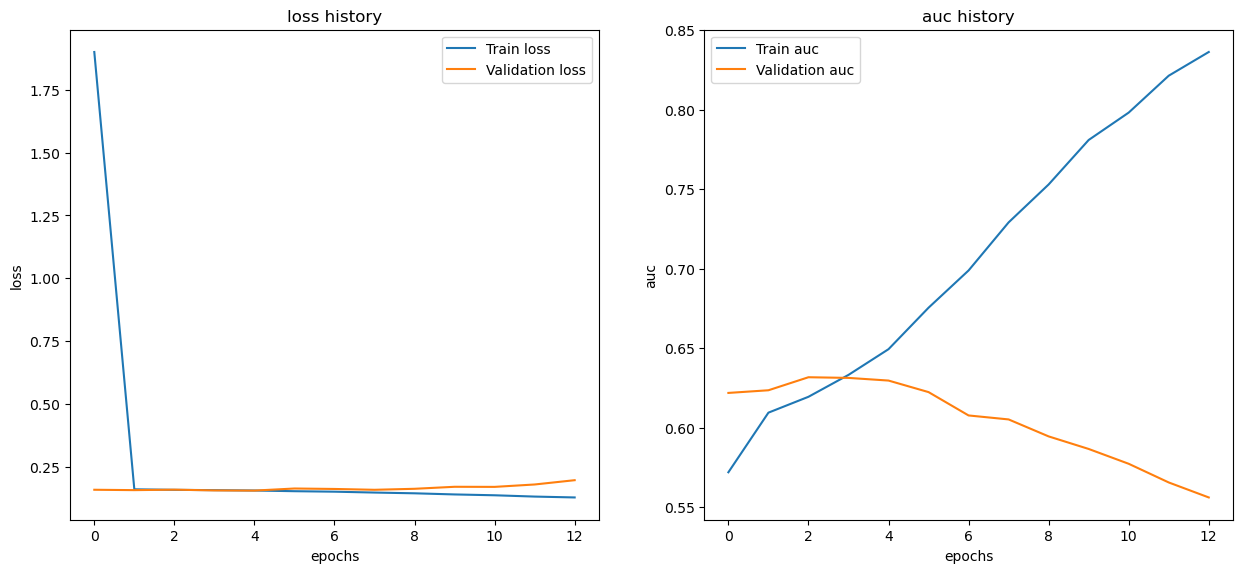

931/931 [==============================] - 2s 2ms/step
[best epoch is 3]	validation_0-gini_dnn: 0.26562

931/931 [==============================] - 1s 2ms/step
CV fold 3
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 34s - loss: 0.0324 - mse: 0.0324 - mae: 0.0907 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.0906 - 34s/epoch - 9ms/step
Epoch 2/50
3721/3721 - 32s - loss: 0.0225 - mse: 0.0225 - mae: 0.0663 - val_loss: 0.0191 - val_mse: 0.0191 - val_mae: 0.0676 - 32s/epoch - 9ms/step
Epoch 3/50
3721/3721 - 32s - loss: 0.0200 - mse: 0.0200 - mae: 0.0571 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0561 - 32s/epoch - 9ms/step
Epoch 4/50
3721/3721 - 32s - loss: 0.0182 - mse: 0.0182 - mae: 0.0512 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0459 - 32s/epoch - 9ms/step
Epoch 5/50
3721/3721 - 32s - loss: 0.0169 - mse: 0.0169 - mae: 0.0471 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0371 - 32s/epoch - 8ms/step
Epoch 6/50
3721/3721 - 35s - loss: 0.0159 - mse: 0.0159 - 

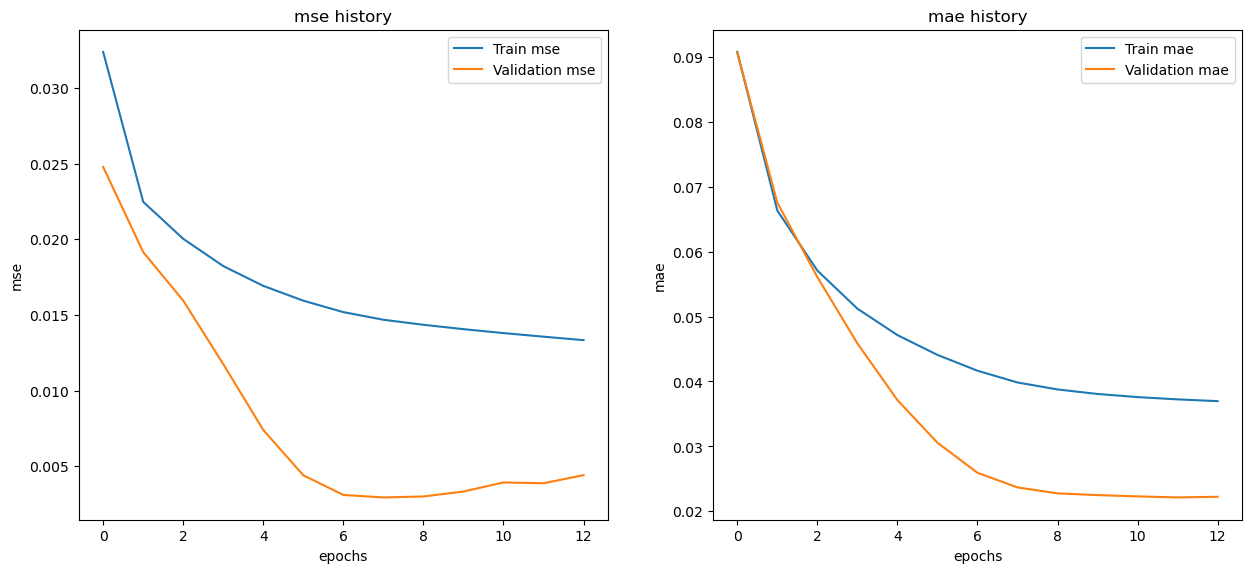

Fitting model
Epoch 1/150
3721/3721 - 19s - loss: 1.9462 - auc: 0.5667 - val_loss: 0.1585 - val_auc: 0.6394 - lr: 0.0010 - 19s/epoch - 5ms/step
Epoch 2/150
3721/3721 - 16s - loss: 0.1602 - auc: 0.6001 - val_loss: 0.1564 - val_auc: 0.6409 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 3/150
3721/3721 - 17s - loss: 0.1577 - auc: 0.6163 - val_loss: 0.1543 - val_auc: 0.6462 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 4/150
3721/3721 - 16s - loss: 0.1563 - auc: 0.6261 - val_loss: 0.1553 - val_auc: 0.6484 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 5/150
3721/3721 - 17s - loss: 0.1548 - auc: 0.6452 - val_loss: 0.1556 - val_auc: 0.6417 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 6/150
3721/3721 - 17s - loss: 0.1537 - auc: 0.6608 - val_loss: 0.1555 - val_auc: 0.6381 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 7/150
3721/3721 - 17s - loss: 0.1510 - auc: 0.6894 - val_loss: 0.1560 - val_auc: 0.6205 - lr: 7.5000e-04 - 17s/epoch - 5ms/step
Epoch 8/150
3721/3721 - 16s - loss: 0.1488 - auc: 0.7116 - val_loss: 0.1

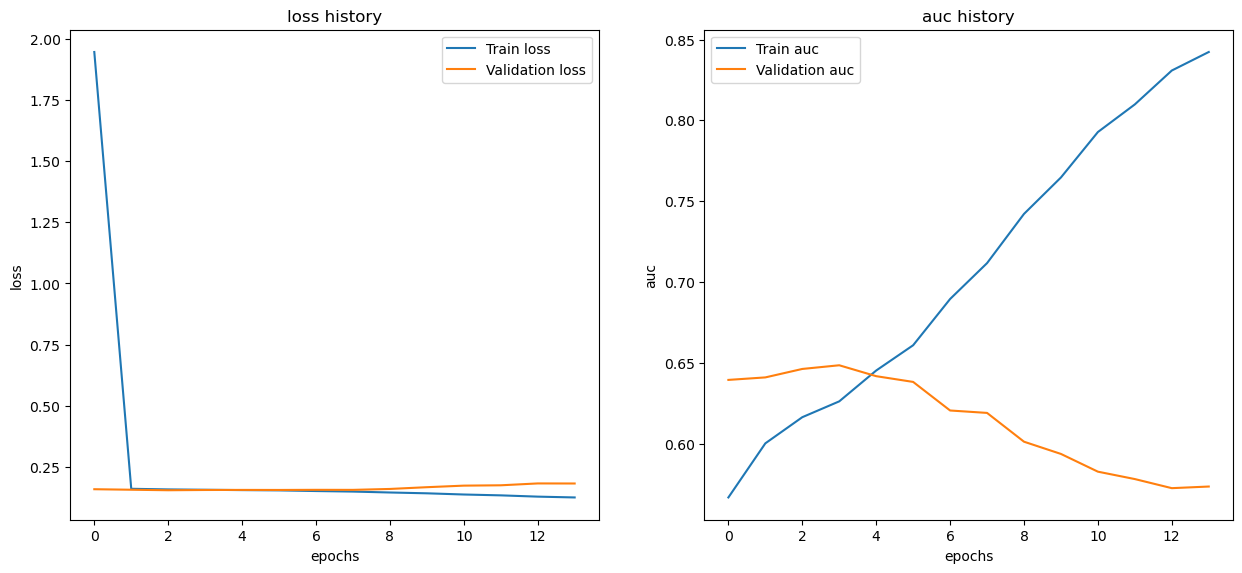

931/931 [==============================] - 2s 2ms/step
[best epoch is 4]	validation_0-gini_dnn: 0.29982

931/931 [==============================] - 2s 2ms/step
CV fold 4
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 38s - loss: 0.0323 - mse: 0.0323 - mae: 0.0910 - val_loss: 0.0222 - val_mse: 0.0222 - val_mae: 0.0925 - 38s/epoch - 10ms/step
Epoch 2/50
3721/3721 - 32s - loss: 0.0221 - mse: 0.0221 - mae: 0.0670 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0727 - 32s/epoch - 8ms/step
Epoch 3/50
3721/3721 - 32s - loss: 0.0196 - mse: 0.0196 - mae: 0.0573 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0554 - 32s/epoch - 9ms/step
Epoch 4/50
3721/3721 - 31s - loss: 0.0179 - mse: 0.0179 - mae: 0.0513 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0459 - 31s/epoch - 8ms/step
Epoch 5/50
3721/3721 - 32s - loss: 0.0168 - mse: 0.0168 - mae: 0.0470 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0395 - 32s/epoch - 8ms/step
Epoch 6/50
3721/3721 - 32s - loss: 0.0158 - mse: 0.0158 -

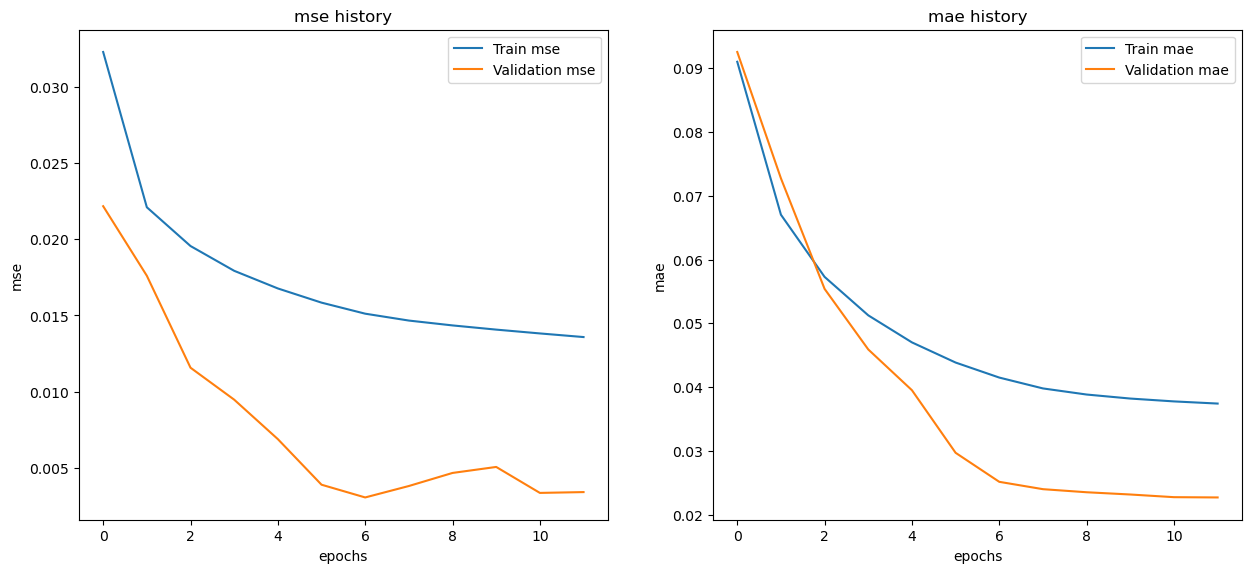

Fitting model
Epoch 1/150
3721/3721 - 19s - loss: 1.9269 - auc: 0.5751 - val_loss: 0.1639 - val_auc: 0.6220 - lr: 0.0010 - 19s/epoch - 5ms/step
Epoch 2/150
3721/3721 - 17s - loss: 0.1601 - auc: 0.6062 - val_loss: 0.1586 - val_auc: 0.6297 - lr: 0.0010 - 17s/epoch - 5ms/step
Epoch 3/150
3721/3721 - 17s - loss: 0.1574 - auc: 0.6201 - val_loss: 0.1556 - val_auc: 0.6349 - lr: 0.0010 - 17s/epoch - 5ms/step
Epoch 4/150
3721/3721 - 16s - loss: 0.1559 - auc: 0.6333 - val_loss: 0.1548 - val_auc: 0.6329 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 5/150
3721/3721 - 16s - loss: 0.1545 - auc: 0.6486 - val_loss: 0.1603 - val_auc: 0.6334 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 6/150
3721/3721 - 16s - loss: 0.1522 - auc: 0.6739 - val_loss: 0.1552 - val_auc: 0.6268 - lr: 7.5000e-04 - 16s/epoch - 4ms/step
Epoch 7/150
3721/3721 - 17s - loss: 0.1503 - auc: 0.6965 - val_loss: 0.1571 - val_auc: 0.6175 - lr: 7.5000e-04 - 17s/epoch - 5ms/step
Epoch 8/150
3721/3721 - 17s - loss: 0.1467 - auc: 0.7295 - val_loss:

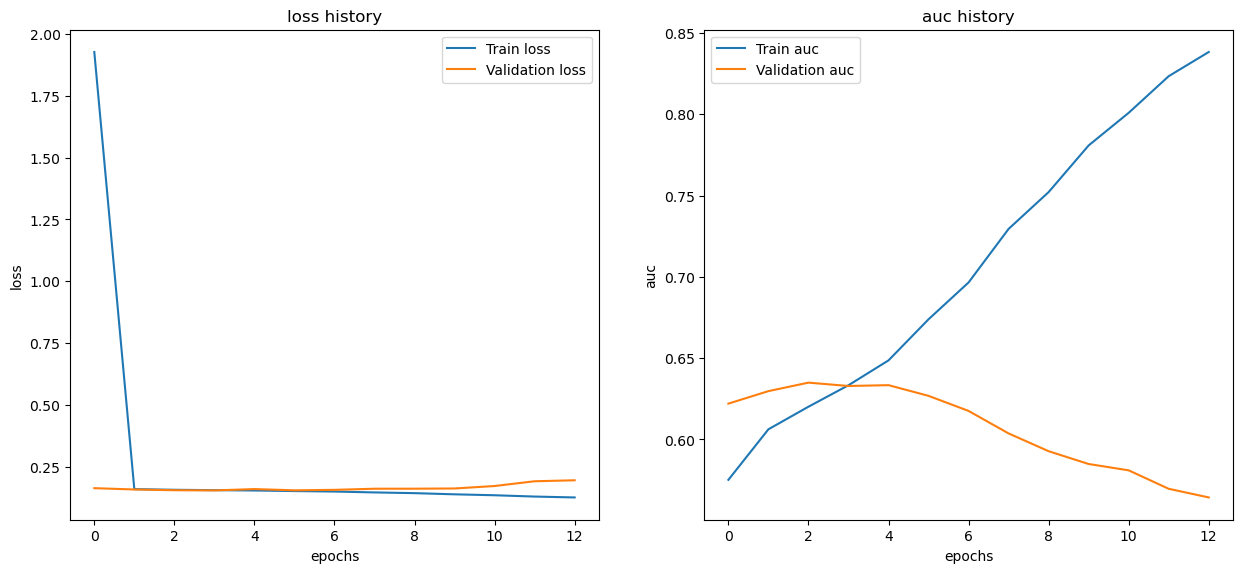

931/931 [==============================] - 2s 2ms/step
[best epoch is 3]	validation_0-gini_dnn: 0.27318

931/931 [==============================] - 1s 2ms/step


In [26]:
preds = np.zeros(len(test))
oof = np.zeros(len(train))
metric_evaluations = list()

skf = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)

for k, (train_idx, valid_idx) in enumerate(skf.split(train, target)):
    print(f"CV fold {k}")
    
    X_train, y_train = train[train_idx, :], target[train_idx]
    X_valid, y_valid = train[valid_idx, :], target[valid_idx]

    if config.reuse_autoencoder:
        print("restoring previously trained dae")
        autoencoder = load_model(f"./dae_fold_{k}")
    else:
        autoencoder = autoencoder_fitting(X_train, X_valid,
                                        filename=f'./dae_fold_{k}', 
                                        random_state=config.random_state)
    
    model, history = model_fitting(X_train, y_train, X_valid, y_valid,
                                autoencoder=autoencoder,
                                filename=f"dnn_model_fold_{k}", 
                                random_state=config.random_state)
    
    val_preds = model.predict(X_valid, batch_size=128)
    best_score = eval_gini(y_true=y_valid, y_pred=np.ravel(val_preds))

    best_epoch = np.argmax(history.history['val_auc']) + 1
    print(f"[best epoch is {best_epoch}]\tvalidation_0-gini_dnn: {best_score:0.5f}\n")
    
    metric_evaluations.append(best_score)
    preds += model.predict(test, batch_size=128).ravel() / skf.n_splits
    oof[valid_idx] = model.predict(X_valid, batch_size=128).ravel()
    
    gpu_cleanup([autoencoder, model])

In [27]:
print(f"DNN CV Gini Normalized Score: {np.mean(metric_evaluations):0.3f} ({np.std(metric_evaluations):0.3f})")

DNN CV Gini Normalized Score: 0.275 (0.015)


<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>4.2 Submission</b></p>
</div>

Saving the submission to the required (according to the competitions evaluation page) submission.csv file.

In [28]:
submission['target'] = preds
submission.to_csv('submission.csv')

In [29]:
oofs = pd.DataFrame({'id':train_index, 'target':oof})
oofs.to_csv('dnn_oof.csv', index=False)

# 5. References

<div style="color:white;display:fill;
            background-color:#48AFFF;font-size:160%;
            font-family:Arial">
    <p style="padding: 4px;color:white;"><b>5.1 References</b></p>
</div>

* Banachewicz, Konrad; Massaron, Luca. [The Kaggle Book](https://www.kaggle.com/general/320574): Data analysis and machine learning for competitive data science. Packt Publishing
* Banachewicz, Konrad; Massaron, Luca. [The Kaggle Workbook](https://www.amazon.com/Kaggle-Workbook-Self-learning-exercises-competitions/dp/1804611212): Self-learning exercises and valuable insights for Kaggle data science competitions. Packt Publishing. 
* [workbook_dae](https://www.kaggle.com/code/lucamassaron/workbook-dae) by [Luca Massaron](https://www.kaggle.com/lucamassaron)
* [Why removing ps_calc features improve the results?](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/discussion/41970) by [Hossein Amirkhani]